## Examination project, June 2024

## Introduction to programming and numerical analysis

**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

We have used AI as an aid in our examination answers. This tool is primarily used when errors arise in our codes, helping us to identify and clarify code.
AI has mainly been used in the following questions: 1.2, 2.3, 3.1.

In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate
from types import SimpleNamespace
import sympy as sm
import random
from scipy import optimize
import matplotlib.pyplot as plt
import warnings
from scipy.optimize import minimize_scalar
from scipy.optimize import root
from scipy.optimize import minimize_scalar, minimize, root

# Autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Predefine options for all plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 10})

## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

In [2]:
par = SimpleNamespace()

# firms
par.A = 1.0
par.gamma = 0.5

# households
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0

# government
par.tau = 0.0
par.T = 0.0

# Question 3
par.kappa = 0.1

In [3]:
class EconomyModel:
    def __init__(self):
        par = self.par = SimpleNamespace()
        # firms
        par.A = 1.0
        par.gamma = 0.5

        # households
        par.alpha = 0.3
        par.nu = 1.0
        par.epsilon = 2.0

        # government
        par.tau = 0.0
        par.T = 0.0
        
        sol = self.sol = SimpleNamespace()
        sol.w = 1 #Numeraire for wage

    def firm_behavior(self, p):
        A, gamma, w = self.par.A, self.par.gamma, self.sol.w
        l_star = (p * A * gamma / w) ** (1 / (1 - gamma))
        y_star = A * (l_star ** gamma)
        pi_star = (1 - gamma) / gamma * w * (p * A * gamma / w) ** (1 / (1 - gamma))
        return l_star, y_star, pi_star

    def consumer_behavior(self, p1, p2, T, tau):
        alpha, nu, epsilon, w = self.par.alpha, self.par.nu, self.par.epsilon, self.sol.w

        def utility(l):
            c1 = alpha * (w * l + T + self.pi1 + self.pi2) / p1
            c2 = (1 - alpha) * (w * l + T + self.pi1 + self.pi2) / (p2 + tau)
            return np.log(c1 ** alpha * c2 ** (1 - alpha)) - nu * l ** (1 + epsilon) / (1 + epsilon)

        res = minimize_scalar(lambda l: -utility(l), bounds=(0, 10), method='bounded')
        l_star = res.x
        c1_star = alpha * (w * l_star + T + self.pi1 + self.pi2) / p1
        c2_star = (1 - alpha) * (w * l_star + T + self.pi1 + self.pi2) / (p2 + tau)
        return l_star, c1_star, c2_star

    def market_clearing(self, p1, p2):
        self.l1, self.y1, self.pi1 = self.firm_behavior(p1)
        self.l2, self.y2, self.pi2 = self.firm_behavior(p2)
        
        T = self.par.tau * (self.y2)
        
        self.l_star, self.c1_star, self.c2_star = self.consumer_behavior(p1, p2, T, self.par.tau)
        
        labor_market = self.l_star - (self.l1 + self.l2)
        good_market_1 = self.c1_star - self.y1
        good_market_2 = self.c2_star - self.y2
        
        return labor_market, good_market_1, good_market_2

    def check_market_clearing(self):
        p1_values = np.linspace(0.1, 2.0, 10)
        p2_values = np.linspace(0.1, 2.0, 10)
        
        for p1 in p1_values:
            for p2 in p2_values:
                labor_market, good_market_1, good_market_2 = self.market_clearing(p1, p2)
                print(f"p1: {p1:.1f}, p2: {p2:.1f}, labor market: {labor_market:.4f}, good market 1: {good_market_1:.4f}, good market 2: {good_market_2:.4f}")

model = EconomyModel()

# Check market clearing conditions
model.check_market_clearing()

p1: 0.1, p2: 0.1, labor market: 0.9933, good market 1: 2.9600, good market 2: 6.9734
p1: 0.1, p2: 0.3, labor market: 0.9645, good market 1: 3.0036, good market 2: 2.1347
p1: 0.1, p2: 0.5, labor market: 0.9063, good market 1: 3.0930, good market 2: 1.1432
p1: 0.1, p2: 0.7, labor market: 0.8194, good market 1: 3.2299, good market 2: 0.6770
p1: 0.1, p2: 0.9, labor market: 0.7047, good market 1: 3.4171, good market 2: 0.3844
p1: 0.1, p2: 1.2, labor market: 0.5632, good market 1: 3.6576, good market 2: 0.1709
p1: 0.1, p2: 1.4, labor market: 0.3961, good market 1: 3.9548, good market 2: 0.0004
p1: 0.1, p2: 1.6, labor market: 0.2044, good market 1: 4.3124, good market 2: -0.1438
p1: 0.1, p2: 1.8, labor market: -0.0106, good market 1: 4.7334, good market 2: -0.2705
p1: 0.1, p2: 2.0, labor market: -0.2481, good market 1: 5.2208, good market 2: -0.3851
p1: 0.3, p2: 0.1, labor market: 0.9645, good market 1: 0.8260, good market 2: 7.0751
p1: 0.3, p2: 0.3, labor market: 0.9357, good market 1: 0.840

The result shows all the prices for good 1 and 2, and also the level of labor for each of these prices. It shows that there are no market clearing solution. It can be seen for the values of labor market, and goods market 1 and 2. The highest value for these is given at p1=p2=0.1, where labor market is equal to 0.993, good market 1 is 2.960 and goods market 2 is 6.973.

**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

In [4]:
class EconomyModel:
    def __init__(self):
        par = self.par = SimpleNamespace()
        # firms
        par.A = 1.0
        par.gamma = 0.5

        # households
        par.alpha = 0.3
        par.nu = 1.0
        par.epsilon = 2.0

        # government
        par.tau = 0.0
        par.T = 0.0
        
        sol = self.sol = SimpleNamespace()
        sol.w = 1 # Numeraire for wage

    def firm_behavior(self, p):
        A, gamma, w = self.par.A, self.par.gamma, self.sol.w
        l_star = (p * A * gamma / w) ** (1 / (1 - gamma))
        y_star = A * (l_star ** gamma)
        pi_star = (1 - gamma) / gamma * w * (p * A * gamma / w) ** (1 / (1 - gamma))
        return l_star, y_star, pi_star

    def consumer_behavior(self, p1, p2, T, tau):
        alpha, nu, epsilon, w = self.par.alpha, self.par.nu, self.par.epsilon, self.sol.w

        def utility(l):
            c1 = alpha * (w * l + T + self.pi1 + self.pi2) / p1
            c2 = (1 - alpha) * (w * l + T + self.pi1 + self.pi2) / (p2 + tau)
            return np.log(c1 ** alpha * c2 ** (1 - alpha)) - nu * l ** (1 + epsilon) / (1 + epsilon)

        res = minimize_scalar(lambda l: -utility(l), bounds=(0, 10), method='bounded')
        l_star = res.x
        c1_star = alpha * (w * l_star + T + self.pi1 + self.pi2) / p1
        c2_star = (1 - alpha) * (w * l_star + T + self.pi1 + self.pi2) / (p2 + tau)
        return l_star, c1_star, c2_star

    def market_clearing(self, prices):
        p1, p2 = prices
        self.l1, self.y1, self.pi1 = self.firm_behavior(p1)
        self.l2, self.y2, self.pi2 = self.firm_behavior(p2)
        
        T = self.par.tau * self.y2
        
        self.l_star, self.c1_star, self.c2_star = self.consumer_behavior(p1, p2, T, self.par.tau)
        
        labor_market = self.l_star - (self.l1 + self.l2)
        good_market_1 = self.c1_star - self.y1
        good_market_2 = self.c2_star - self.y2
        
        return [labor_market, good_market_1]

    def find_equilibrium(self):
        # Define the function to find the root of
        def equilibrium_conditions(prices):
            return self.market_clearing(prices)
        
        # Initial guess for prices
        initial_guess = [1.0, 1.0]
        
        # Find the root
        result = root(equilibrium_conditions, initial_guess, method='hybr')
        
        if result.success:
            p1, p2 = result.x
            return p1, p2
        else:
            raise ValueError("Equilibrium prices not found")

model = EconomyModel()

# Find the equilibrium prices
p1_eq, p2_eq = model.find_equilibrium()
print(f"Equilibrium prices: p1 = {p1_eq:.4f}, p2 = {p2_eq:.4f}")


Equilibrium prices: p1 = 0.9759, p2 = 1.4908


The equilibrium price reflects the market, where the optimal consumption level is equal to the optimal level of output, y. In our case, this has been determined to be around 0.9759 for good 1 and 1.4908 for good 2. 

Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

In [5]:
class EconomyModel:
    def __init__(self):
        par = self.par = SimpleNamespace()
        # firms
        par.A = 1.0
        par.gamma = 0.5

        # households
        par.alpha = 0.3
        par.nu = 1.0
        par.epsilon = 2.0

        # government
        par.tau = 0.0
        par.T = 0.0
        
        # social cost of carbon
        par.kappa = 0.1

        sol = self.sol = SimpleNamespace()
        sol.w = 1 # Numeraire for wage

    def firm_behavior(self, p):
        A, gamma, w = self.par.A, self.par.gamma, self.sol.w
        l_star = (p * A * gamma / w) ** (1 / (1 - gamma))
        y_star = A * (l_star ** gamma)
        pi_star = (1 - gamma) / gamma * w * (p * A * gamma / w) ** (1 / (1 - gamma))
        return l_star, y_star, pi_star

    def consumer_behavior(self, p1, p2, T, tau):
        alpha, nu, epsilon, w = self.par.alpha, self.par.nu, self.par.epsilon, self.sol.w

        def utility(l):
            c1 = alpha * (w * l + T + self.pi1 + self.pi2) / p1
            c2 = (1 - alpha) * (w * l + T + self.pi1 + self.pi2) / (p2 + tau)
            return np.log(c1 ** alpha * c2 ** (1 - alpha)) - nu * l ** (1 + epsilon) / (1 + epsilon)

        res = minimize_scalar(lambda l: -utility(l), bounds=(0, 10), method='bounded')
        l_star = res.x
        c1_star = alpha * (w * l_star + T + self.pi1 + self.pi2) / p1
        c2_star = (1 - alpha) * (w * l_star + T + self.pi1 + self.pi2) / (p2 + tau)
        return l_star, c1_star, c2_star, utility(l_star)

    def market_clearing(self, prices, tau):
        p1, p2 = prices
        self.l1, self.y1, self.pi1 = self.firm_behavior(p1)
        self.l2, self.y2, self.pi2 = self.firm_behavior(p2)
        
        T = tau * self.y2
        
        self.l_star, self.c1_star, self.c2_star, self.utility = self.consumer_behavior(p1, p2, T, tau)
        
        labor_market = self.l_star - (self.l1 + self.l2)
        good_market_1 = self.c1_star - self.y1
        good_market_2 = self.c2_star - self.y2
        
        return [labor_market, good_market_1, good_market_2]

    def social_welfare(self, tau):
        def equilibrium_conditions(prices):
            return self.market_clearing(prices, tau)[:2] # Use Walras' law, so only check two conditions
        
        # Initial guess for prices
        initial_guess = [1.0, 1.0]
        
        # Find the root
        result = root(equilibrium_conditions, initial_guess, method='hybr')
        
        if result.success:
            p1, p2 = result.x
            self.market_clearing([p1, p2], tau) # Compute equilibrium values
            y2_star = self.y2
            U = self.utility
            SWF = U - self.par.kappa * y2_star
            return -SWF  # Minimize negative SWF to maximize SWF
        else:
            raise ValueError("Equilibrium prices not found")

    def find_optimal_tau(self):
        # Initial guess for tau
        initial_guess = [0.1]
        
        # Find the optimal tau
        result = minimize(lambda tau: self.social_welfare(tau[0]), initial_guess, bounds=[(0, 2)])
        
        if result.success:
            tau_opt = result.x[0]
            T_opt = tau_opt * self.y2
            return tau_opt, T_opt
        else:
            raise ValueError("Optimal tau not found")

model = EconomyModel()

# Find the optimal tau and T
tau_opt, T_opt = model.find_optimal_tau()
print(f"Optimal tau: {tau_opt:.4f}, Implied T: {T_opt:.4f}")

Optimal tau: 0.1668, Implied T: 0.1207


The lump-sum transfer of 0.1207 indicates an amount that provides sufficient income support to households, enhancing their utility without causing significant disincentives to work. The optimal tax rate of 0.1668 ensures that the labor market clears with the optimal level of employment, while the transfer ensures sufficient demand for goods produced.

## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [6]:
par = SimpleNamespace()
par.J = 3
par.N = 10
par.K = 10000

par.F = np.arange(1,par.N+1)
par.sigma = 2

par.v = np.array([1,2,3])
par.c = 1

**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


We simulate and calculate expected utility and average realised utlity for K=10000 draws

In [7]:
# Initializing arrays to store our results
realized_utilities = np.zeros((par.J, par.K))

# Simulating random distribution and calculating utilities
for j in range(par.J):
    epsilon = np.random.normal(0, par.sigma, par.K)
    realized_utilities[j, :] = par.v[j]

# Calculating expected utility for each career track
expected_utilities = par.v + np.mean(realized_utilities - par.v[:, np.newaxis], axis=1)

# Calculating average realized utility for each career track
average_realized_utilities = np.mean(realized_utilities, axis=1)

# Displaying results
results = pd.DataFrame({
    'Career Track': ['1', '2', '3'],
    'Expected Utility': expected_utilities,
    'Average Realized Utility': average_realized_utilities
})

print(results)

  Career Track  Expected Utility  Average Realized Utility
0            1               1.0                       1.0
1            2               2.0                       2.0
2            3               3.0                       3.0


We observe same results for expected utility and average utility. This is due to the Law of Large Numbers. K is a large number which means the sample mean of the simulated utilities converges to the expected value. Thus, the computed values will be the same.

As seen in the computed results, a small K yields different results for the expected utility and average realized utility. This means that The Law of Large Numbers doesn't apply to small values of K.

Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

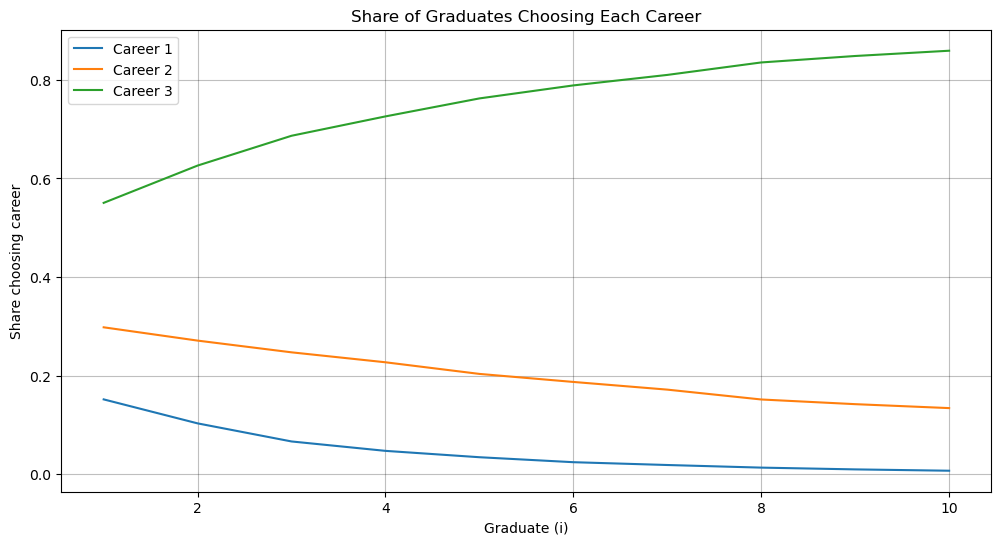

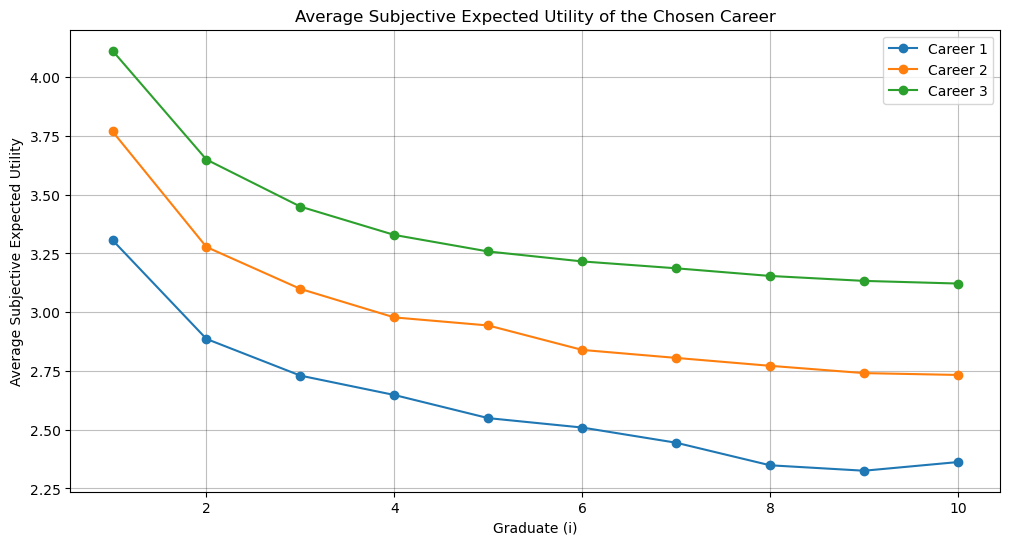

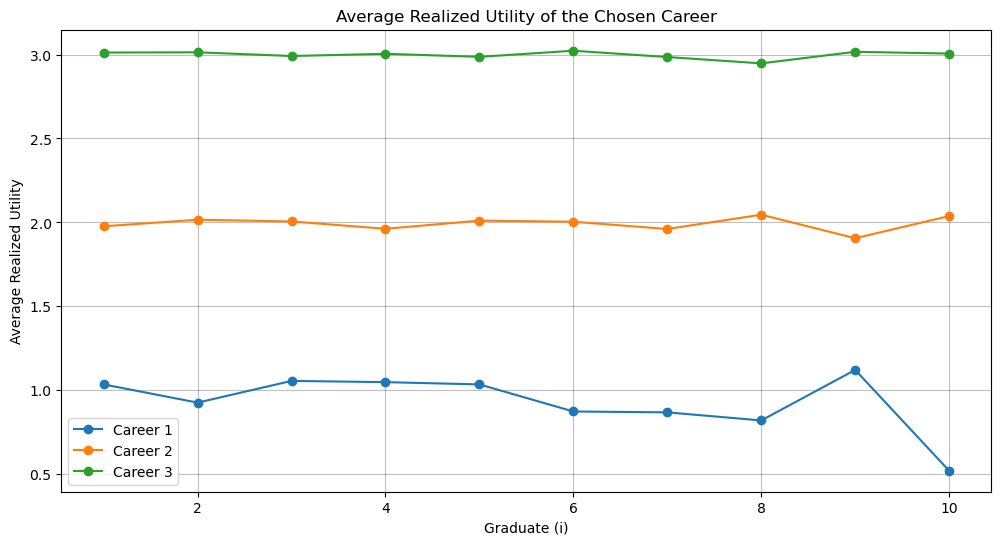

In [8]:
# Initialize arrays to store results
chosen_careers = np.zeros((par.N, par.K), dtype=int)
prior_expectations = np.zeros((par.N, par.K))
realized_utilities = np.zeros((par.N, par.K))

# Simulation process
for k in range(par.K):
    for i in range(par.N):
        F_i = i + 1
        prior_exp_util = np.zeros(par.J)
        
        # Compute prior expected utilities based on friends' utilities
        for j in range(par.J):
            epsilon_friends = np.random.normal(0, par.sigma, F_i)
            prior_exp_util[j] = par.v[j] + np.mean(epsilon_friends)
        
        # Draw own noise terms
        epsilon_own = np.random.normal(0, par.sigma, par.J)
        
        # Choose the career with the highest prior expected utility
        chosen_career = np.argmax(prior_exp_util)
        chosen_careers[i, k] = chosen_career
        prior_expectations[i, k] = prior_exp_util[chosen_career]
        realized_utilities[i, k] = par.v[chosen_career] + epsilon_own[chosen_career]

# Calculate aggregated results
career_shares = np.zeros((par.N, par.J))
avg_prior_expectations = np.zeros((par.N, par.J))
avg_realized_utilities = np.zeros((par.N, par.J))

for i in range(par.N):
    for j in range(par.J):
        career_shares[i, j] = np.mean(chosen_careers[i, :] == j)
        avg_prior_expectations[i, j] = np.mean(prior_expectations[i, chosen_careers[i, :] == j])
        avg_realized_utilities[i, j] = np.mean(realized_utilities[i, chosen_careers[i, :] == j])

# Visualization
# Share of graduates choosing each career
plt.figure(figsize=(12, 6))
for j in range(par.J):
    plt.plot(range(1, par.N + 1), career_shares[:, j], label=f'Career {j+1}')
plt.xlabel('Graduate (i)')
plt.ylabel('Share choosing career')
plt.title('Share of Graduates Choosing Each Career')
plt.legend()
plt.show()

# Average subjective expected utility of the chosen career
plt.figure(figsize=(12, 6))
for j in range(par.J):
    plt.plot(range(1, par.N + 1), avg_prior_expectations[:, j], marker='o', label=f'Career {j+1}')
plt.xlabel('Graduate (i)')
plt.ylabel('Average Subjective Expected Utility')
plt.title('Average Subjective Expected Utility of the Chosen Career')
plt.legend()
plt.show()

# Average realized utility of the chosen career
plt.figure(figsize=(12, 6))
for j in range(par.J):
    plt.plot(range(1, par.N + 1), avg_realized_utilities[:, j], marker='o', label=f'Career {j+1}')
plt.xlabel('Graduate (i)')
plt.ylabel('Average Realized Utility')
plt.title('Average Realized Utility of the Chosen Career')
plt.legend()
plt.show()


We comment on the plots.

Share of graduates choosing career: There's an increasing trend for career track 3 in graduates. Careers 2 and 3 are decreasing in graduates. This would indicate that a larger share of graduates tend to choose career track 3 as the number of friends in the different career track increases. One possibile explanation may be that having more friends in each career track leads to more information about said career, thus learning more about its value.

Average Subjective Expected Utility of the Chosen Career: 

Average Realized Utility of the Chosen Career:

After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

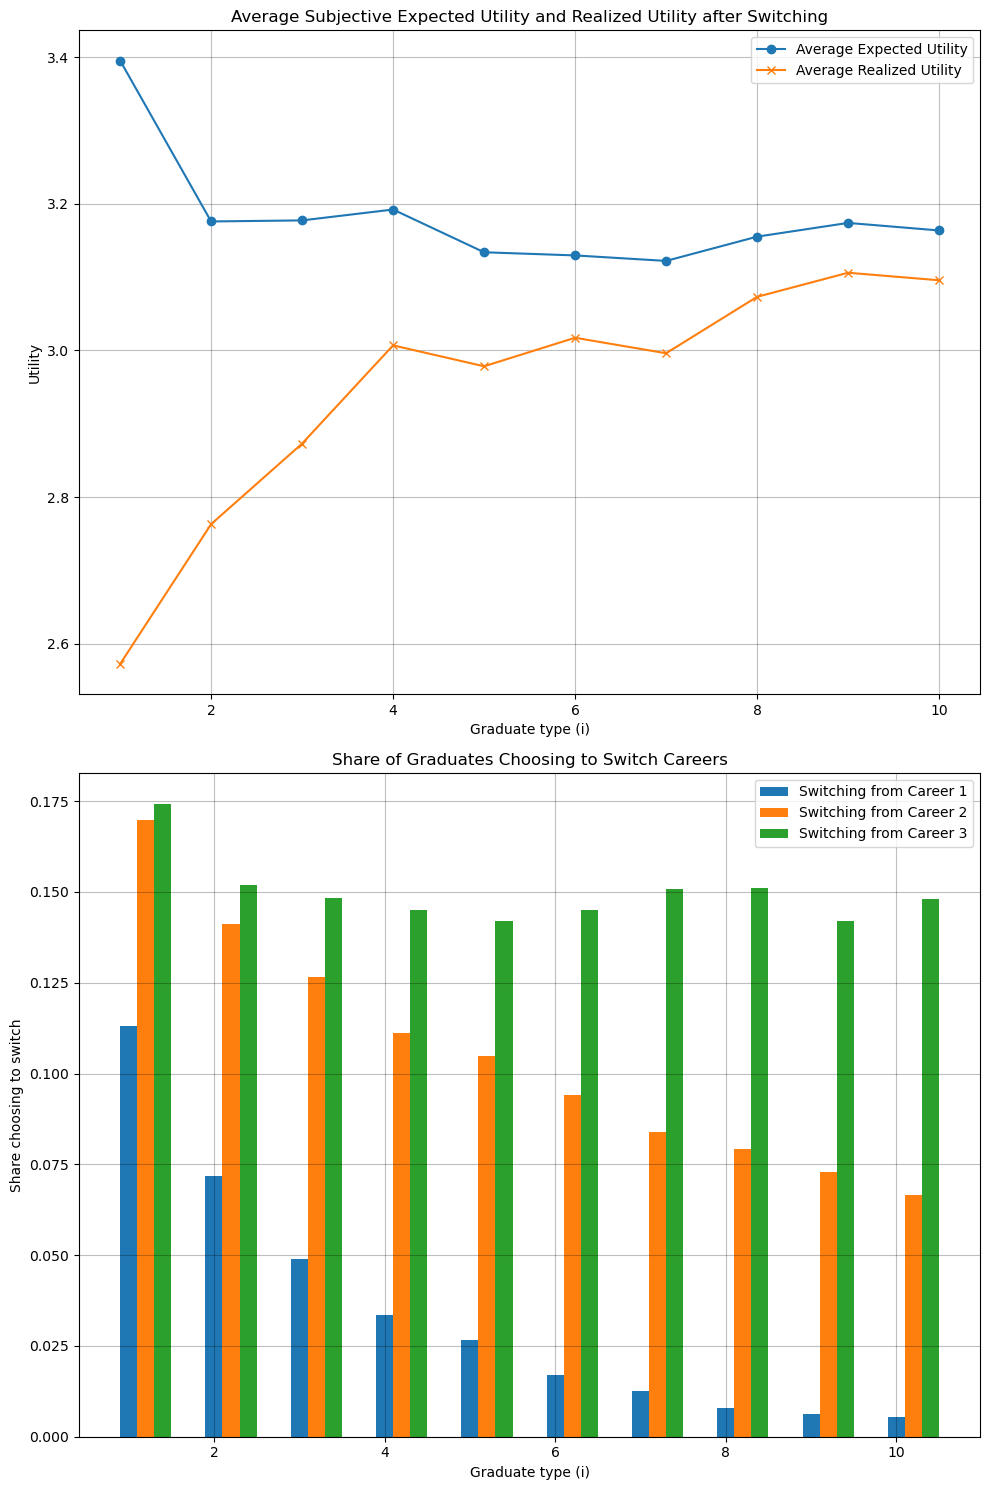

In [9]:
# Define parameters
par = SimpleNamespace()
par.J = 3
par.N = 10
par.K = 10000
par.sigma = 2
par.c = 1

par.v = np.array([1, 2, 3])

# Initialize arrays to store results
chosen_careers = np.zeros((par.N, par.K), dtype=int)
expected_utilities = np.zeros((par.N, par.K))
realized_utilities = np.zeros((par.N, par.K))

# Perform the simulation for the first year
for k in range(par.K):
    for i in range(par.N):
        F_i = i + 1
        prior_expected_utilities = np.zeros(par.J)
        
        for j in range(par.J):
            epsilon_fj = np.random.normal(0, par.sigma, F_i)
            prior_expected_utilities[j] = par.v[j] + np.mean(epsilon_fj)
        
        # Graduate i chooses the career track with the highest expected utility
        chosen_career = np.argmax(prior_expected_utilities)
        chosen_careers[i, k] = chosen_career
        
        # Calculate the expected utility and realized utility for the chosen career
        epsilon_ij = np.random.normal(0, par.sigma)
        expected_utilities[i, k] = prior_expected_utilities[chosen_career]
        realized_utilities[i, k] = par.v[chosen_career] + epsilon_ij

# Initialize arrays to store second year results
new_chosen_careers = np.zeros((par.N, par.K), dtype=int)
new_expected_utilities = np.zeros((par.N, par.K))
new_realized_utilities = np.zeros((par.N, par.K))

# Perform the simulation for the second year
for k in range(par.K):
    for i in range(par.N):
        F_i = i + 1
        initial_career = chosen_careers[i, k]
        initial_realized_utility = realized_utilities[i, k]
        
        new_prior_expected_utilities = np.zeros(par.J)
        new_realized_utilities[i, k] = initial_realized_utility
        
        for j in range(par.J):
            if j == initial_career:
                new_prior_expected_utilities[j] = initial_realized_utility
            else:
                epsilon_fj = np.random.normal(0, par.sigma, F_i)
                new_prior_expected_utilities[j] = par.v[j] + np.mean(epsilon_fj) - par.c
        
        # Graduate i chooses the new career track with the highest expected utility
        new_chosen_career = np.argmax(new_prior_expected_utilities)
        new_chosen_careers[i, k] = new_chosen_career
        
        if new_chosen_career != initial_career:
            epsilon_ij = np.random.normal(0, par.sigma)
            new_realized_utilities[i, k] = par.v[new_chosen_career] + epsilon_ij - par.c

        new_expected_utilities[i, k] = new_prior_expected_utilities[new_chosen_career]

# Calculate the share of graduates choosing to switch careers
switch_share = np.zeros((par.N, par.J))
for i in range(par.N):
    for j in range(par.J):
        switch_share[i, j] = np.mean((chosen_careers[i, :] == j) & (new_chosen_careers[i, :] != j))

# Calculate the average subjective expected utility and average ex post realized utility for each type of graduate
average_new_expected_utilities = np.mean(new_expected_utilities, axis=1)
average_new_realized_utilities = np.mean(new_realized_utilities, axis=1)

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 15))

# Average subjective expected utility and realized utility
x = np.arange(1, par.N + 1)
axs[0].plot(x, average_new_expected_utilities, marker='o', label='Average Expected Utility')
axs[0].plot(x, average_new_realized_utilities, marker='x', label='Average Realized Utility')
axs[0].set_xlabel('Graduate type (i)')
axs[0].set_ylabel('Utility')
axs[0].set_title('Average Subjective Expected Utility and Realized Utility after Switching')
axs[0].legend()

# Share of graduates choosing to switch careers
width = 0.2  # width of the bars
for j in range(par.J):
    axs[1].bar(x + j*width, switch_share[:, j], width, label=f'Switching from Career {j+1}')
axs[1].set_xlabel('Graduate type (i)')
axs[1].set_ylabel('Share choosing to switch')
axs[1].set_title('Share of Graduates Choosing to Switch Careers')
axs[1].legend()

plt.tight_layout()
plt.show()


The plots show that average expected utility decrease when switching careers after one year, particularly among those with higher graduate type. Additionally, average realized utility increases for higher graduates types. We observe inverse correlation. 


The share of graduate choosing to switch careers shows that the actual realised utility is increasing, indicating that the utility of the individuals actually increase. Also, it shows that for career 1 and 2, the rate of changing careers is lower the greater the graduate type is, whereas for the career 3 individuals, they seem to change in the same high rate. As seen in the graph, approximately 17.6% of those in career 3  for graduate type 1 choose to switch after a year compared to approximately 11% for those in career 1. For graduate type 10, it can be seen that switches for career 1 is around 1%, and 15% for career 3. 

## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [10]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))

**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

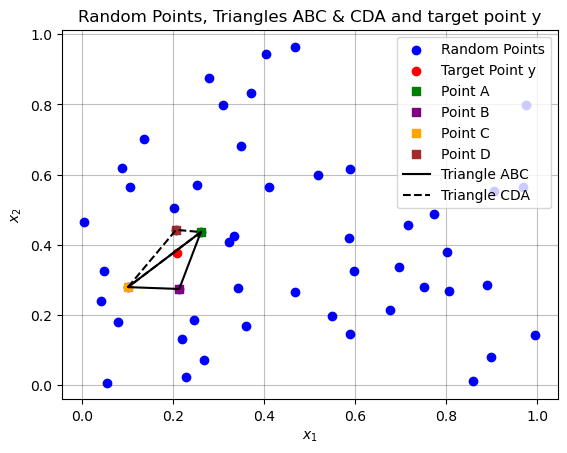

In [11]:
# Defining function to find points A, B, C, D
def find_ABCD_points(X, y):
    A = B = C = D = None
    min_dist_A = min_dist_B = min_dist_C = min_dist_D = float('inf')

    for point in X:
        x1, x2 = point
        dist = np.sqrt((x1 - y[0])**2 + (x2 - y[1])**2)

        if x1 > y[0] and x2 > y[1] and dist < min_dist_A:
            A = point
            min_dist_A = dist
        elif x1 > y[0] and x2 < y[1] and dist < min_dist_B:
            B = point
            min_dist_B = dist
        elif x1 < y[0] and x2 < y[1] and dist < min_dist_C:
            C = point
            min_dist_C = dist
        elif x1 < y[0] and x2 > y[1] and dist < min_dist_D:
            D = point
            min_dist_D = dist

    return A, B, C, D

A, B, C, D = find_ABCD_points(X, y)

# Defining function to plot points and triangles ABC, CDA
def plot_points_and_triangles(X, y, A, B, C, D):
    plt.scatter(X[:, 0], X[:, 1], c='blue', label='Random Points')
    plt.scatter(y[0], y[1], c='red', label='Target Point y')
    
    if A is not None:
        plt.scatter(A[0], A[1], c='green', marker='s', label='Point A')
    if B is not None:
        plt.scatter(B[0], B[1], c='purple', marker='s', label='Point B')
    if C is not None:
        plt.scatter(C[0], C[1], c='orange', marker='s', label='Point C')
    if D is not None:
        plt.scatter(D[0], D[1], c='brown', marker='s', label='Point D')

    if A is not None and B is not None and C is not None:
        plt.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], 'k-', label='Triangle ABC')
    if C is not None and D is not None and A is not None:
        plt.plot([C[0], D[0], A[0], C[0]], [C[1], D[1], A[1], C[1]], 'k--', label='Triangle CDA')
    
    plt.legend()
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title('Random Points, Triangles ABC & CDA and target point y')
    plt.show()

# Plotting
plot_points_and_triangles(X, y, A, B, C, D)

We find the points A, B , C and D. The computed points are used to make up the two triangles ABC and CDA as illustrated in the plot.

**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

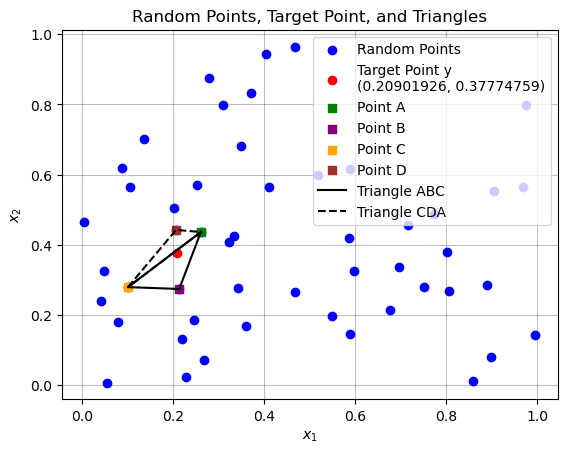

Barycentric coordinates, triangle ABC: 0.6286263152916166, 0.06910145494351515, 0.3022722297648682
Barycentric coordinates, triangle CDA: 0.6286263152916166, 0.06910145494351515, 0.3022722297648682
Location of Point y is triangle: ABC
The coordinates for the target point y are computed as: (0.2090192612295143, 0.3777475872869961)


In [12]:
# Defining function to compute Barycentric coordinates
def barycentric_coordinates(A, B, C, y):
    d = (B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1])
    r1 = ((B[1] - C[1]) * (y[0] - C[0]) + (C[0] - B[0]) * (y[1] - C[1])) / d
    r2 = ((C[1] - A[1]) * (y[0] - C[0]) + (A[0] - C[0]) * (y[1] - C[1])) / d
    r3 = 1 - r1 - r2
    return r1, r2, r3

# Using previously defined function to plot points and triangles ABC, CDA
def plot_points_and_triangles(X, y, A, B, C, D):
    plt.scatter(X[:, 0], X[:, 1], c='blue', label='Random Points')
    plt.scatter(y[0], y[1], c='red', label='Target Point y\n({:.8f}, {:.8f})'.format(y[0], y[1]))
    
    if A is not None:
        plt.scatter(A[0], A[1], c='green', marker='s', label='Point A')
    if B is not None:
        plt.scatter(B[0], B[1], c='purple', marker='s', label='Point B')
    if C is not None:
        plt.scatter(C[0], C[1], c='orange', marker='s', label='Point C')
    if D is not None:
        plt.scatter(D[0], D[1], c='brown', marker='s', label='Point D')

    if A is not None and B is not None and C is not None:
        plt.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], 'k-', label='Triangle ABC')
    if C is not None and D is not None and A is not None:
        plt.plot([C[0], D[0], A[0], C[0]], [C[1], D[1], A[1], C[1]], 'k--', label='Triangle CDA')
    
    plt.legend()
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title('Random Points, Target Point, and Triangles')
    plt.show()

# Find the closest points
A, B, C, D = find_ABCD_points(X, y)

# Computing triangles ABC and CDA by using defined Barycentric coordinates
if A is not None and B is not None and C is not None:
    r1_ABC, r2_ABC, r3_ABC = barycentric_coordinates(A, B, C, y)
else:
    r1_ABC = r2_ABC = r3_ABC = None

if C is not None and D is not None and A is not None:
    r1_CDA, r2_CDA, r3_CDA = barycentric_coordinates(A, B, C, y)
else:
    r1_CDA = r2_CDA = r3_CDA = None

# Determining  which triangle y is located in
if r1_ABC is not None and 0 <= r1_ABC <= 1 and 0 <= r2_ABC <= 1 and 0 <= r3_ABC <= 1:
    triangle = "ABC"
elif r1_CDA is not None and 0 <= r1_CDA <= 1 and 0 <= r2_CDA <= 1 and 0 <= r3_CDA <= 1:
    triangle = "CDA"
else:
    triangle = "None"

# Plotting points and triangles
plot_points_and_triangles(X, y, A, B, C, D)

# Printing results
print(f"Barycentric coordinates, triangle ABC: {r1_ABC}, {r2_ABC}, {r3_ABC}")
print(f"Barycentric coordinates, triangle CDA: {r1_CDA}, {r2_CDA}, {r3_CDA}")
print(f"Location of Point y is triangle: {triangle}")

# Priting coordinates for the target point y
y_coordinates_full_precision = (y[0], y[1])
print(f'The coordinates for the target point y are computed as: {y_coordinates_full_precision}')

In question 1, the target point y was seen located in ABC. The Barycentric coordinates of the point y with respect to the two triangles ABC and CDA are computed: (0.2090192612295143, 0.3777475872869961). Together, these coordinates make up target point y which is located in triangle ABC. 

Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [13]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

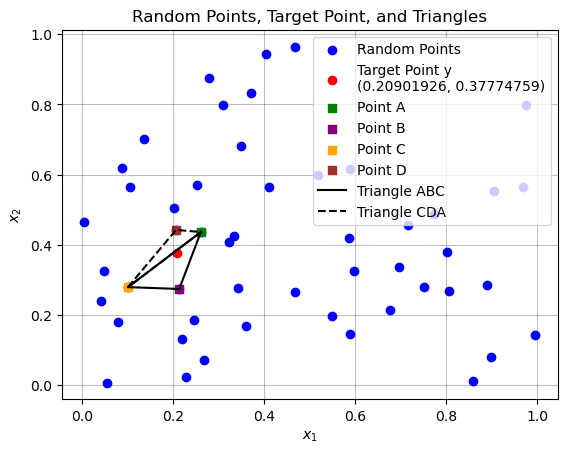

Approximation of f(y): 0.08405202
True value of f(y): 0.07895652
Difference: -0.00509550


In [14]:
def is_inside_triangle(r1, r2, r3):
    return 0 <= r1 <= 1 and 0 <= r2 <= 1 and 0 <= r3 <= 1

# Find closest points A, B, C, D
A, B, C, D = find_ABCD_points(X, y)

# Plot the points and triangles
plot_points_and_triangles(X, y, A, B, C, D)

# Approximate f(y) using the triangles
approx_f_y = np.nan

if A is not None and B is not None and C is not None:
    r1, r2, r3 = barycentric_coordinates(A, B, C, y)
    if is_inside_triangle(r1, r2, r3):
        approx_f_y = r1 * f(A) + r2 * f(B) + r3 * f(C)

if C is not None and D is not None and A is not None and np.isnan(approx_f_y):
    r1, r2, r3 = barycentric_coordinates(C, D, A, y)
    if is_inside_triangle(r1, r2, r3):
        approx_f_y = r1 * f(C) + r2 * f(D) + r3 * f(A)

true_f_y = f(y)

# Printing results
print(f"Approximation of f(y): {approx_f_y:.8f}")
print(f"True value of f(y): {true_f_y:.8f}")
print(f"Difference: {true_f_y - approx_f_y:.8f}")

Using the algorithm, we have computed the approximation- and true value of f(y). There's a slight difference between the two. In the first part of the algorithm, all possible points are returned. We use the second and third parts of the algorithm to determine in which triangle y is located. This has previous been determined as triangle ABC. 

**Question 4:** Repeat question 3 for all points in the set $Y$.

In [15]:
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)]

By repeating question 3 for all points in the set Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)], four plots are constructed. We assume coodinates second and fourth to be the same.  

Point y = (0.2, 0.2) -> Approximated value: 0.04032631372248057, True value: 0.04000000000000001, Triangle: ABC
Point y = (0.8, 0.2) -> Approximated value: 0.15874233999349835, True value: 0.16000000000000003, Triangle: ABC
Point y = (0.8, 0.8) -> Approximated value: nan, True value: 0.6400000000000001, Triangle: None
Point y = (0.8, 0.2) -> Approximated value: 0.15874233999349835, True value: 0.16000000000000003, Triangle: ABC
Point y = (0.5, 0.5) -> Approximated value: 0.2512901561119622, True value: 0.25, Triangle: ABC


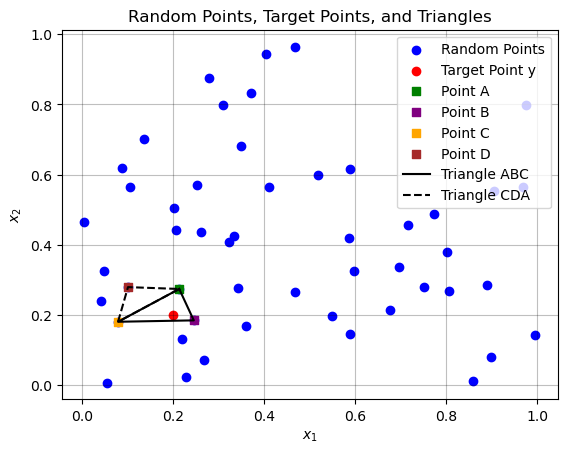

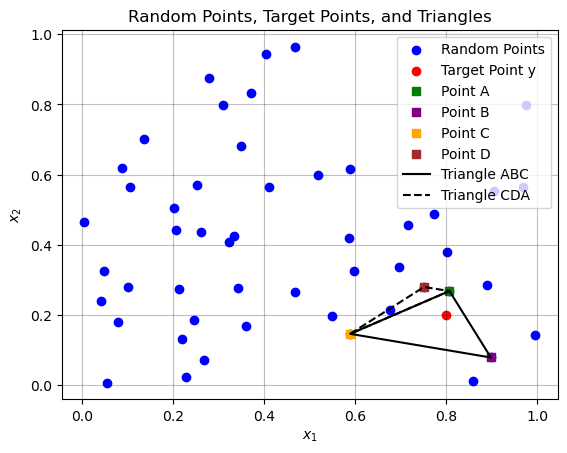

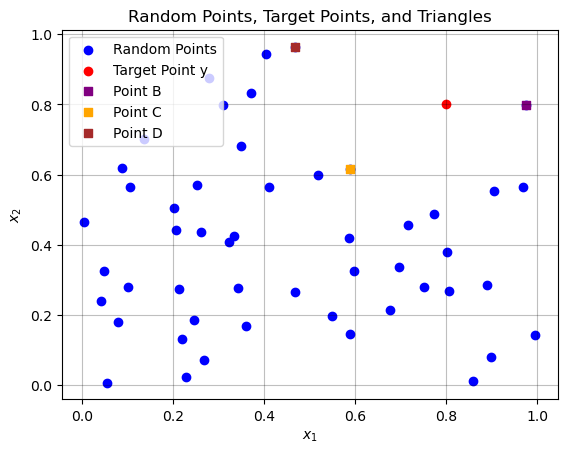

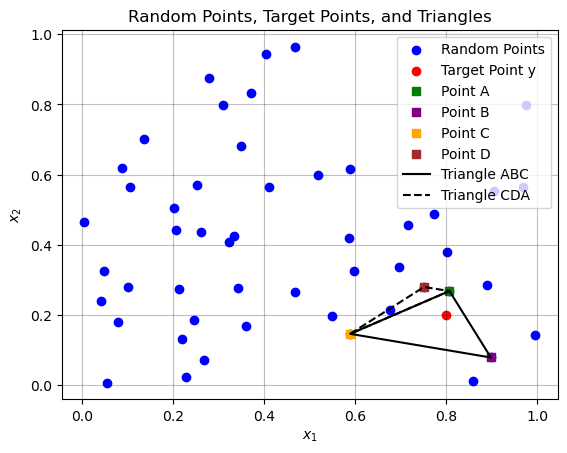

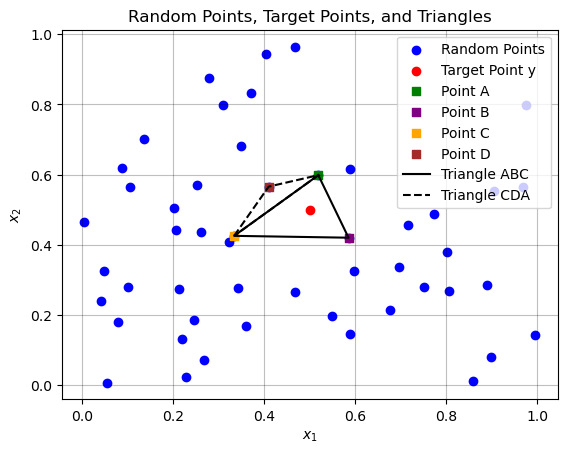

In [16]:
# Function to plot points and triangles for all points in Y
def plot_points_and_triangles_for_all(X, Y, A, B, C, D):
    plt.scatter(X[:, 0], X[:, 1], c='blue', label='Random Points')
    
    for y in Y:
        plt.scatter(y[0], y[1], c='red', label='Target Point y')
    
    if A is not None:
        plt.scatter(A[0], A[1], c='green', marker='s', label='Point A')
    if B is not None:
        plt.scatter(B[0], B[1], c='purple', marker='s', label='Point B')
    if C is not None:
        plt.scatter(C[0], C[1], c='orange', marker='s', label='Point C')
    if D is not None:
        plt.scatter(D[0], D[1], c='brown', marker='s', label='Point D')

    if A is not None and B is not None and C is not None:
        plt.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], 'k-', label='Triangle ABC')
    if C is not None and D is not None and A is not None:
        plt.plot([C[0], D[0], A[0], C[0]], [C[1], D[1], A[1], C[1]], 'k--', label='Triangle CDA')
    
    plt.legend()
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title('Random Points, Target Points, and Triangles')
    plt.show()

# Iterate over each point in Y and compute the approximations
results = []
for y in Y:
    A, B, C, D = find_ABCD_points(X, y)

    if A is not None and B is not None and C is not None:
        r1_ABC, r2_ABC, r3_ABC = barycentric_coordinates(A, B, C, y)
    else:
        r1_ABC = r2_ABC = r3_ABC = None

    if C is not None and D is not None and A is not None:
        r1_CDA, r2_CDA, r3_CDA = barycentric_coordinates(C, D, A, y)
    else:
        r1_CDA = r2_CDA = r3_CDA = None

    if r1_ABC is not None and is_inside_triangle(r1_ABC, r2_ABC, r3_ABC):
        approx_f_y = r1_ABC * f(A) + r2_ABC * f(B) + r3_ABC * f(C)
        triangle = "ABC"
    elif r1_CDA is not None and is_inside_triangle(r1_CDA, r2_CDA, r3_CDA):
        approx_f_y = r1_CDA * f(C) + r2_CDA * f(D) + r3_CDA * f(A)
        triangle = "CDA"
    else:
        approx_f_y = np.nan
        triangle = "None"

    true_f_y = f(y)
    results.append((y, approx_f_y, true_f_y, triangle))

# Output the results
for res in results:
    y, approx_f_y, true_f_y, triangle = res
    print(f"Point y = {y} -> Approximated value: {approx_f_y}, True value: {true_f_y}, Triangle: {triangle}")

# Plot the points and triangles for each y
for y in Y:
    A, B, C, D = find_ABCD_points(X, y)
    plot_points_and_triangles_for_all(X, [y], A, B, C, D)

We observe that target point y always is located in triangle ABC. However, both triangles differ in size and location in the plots. At point y=(0.8, 0.8), no trinagle was computed. For this point of y, the approximated value is nan.

For point y=(0.2, 0.2), the approximated value is 0.0403 and the true value is 0.0400.

For point y=(0.8, 0.2), the approximated value is 0.1587 and the true value is 0.1600.

For point y=(0.8, 0.8), the approximated value is nan and the true value is 0.6400. No triangle.

For point y=(0.5, 0.5), the approximated value is 0.2513 and the true value is 0.2500.